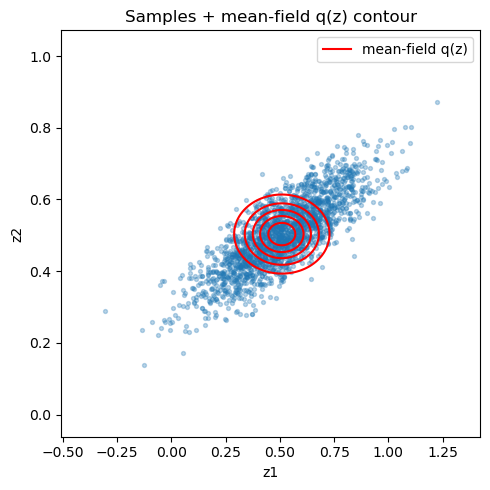

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import matplotlib.lines as mlines

np.random.seed(0)

# ----- 1. 造数据 -----
mu_true = np.array([0.5, 0.5])
sigma1, sigma2 = 0.2, 0.1
rho = 0.8
cov_true = np.array([
    [sigma1**2, rho * sigma1 * sigma2],
    [rho * sigma1 * sigma2, sigma2**2]
])
N = 2000
Z = np.random.multivariate_normal(mu_true, cov_true, size=N)

# ----- 2. 估计 p 的参数 -----
mu_hat = Z.mean(axis=0)
cov_hat = np.cov(Z, rowvar=False)
Lambda_hat = np.linalg.inv(cov_hat)

# ----- 3. mean-field q 参数 -----
m1, m2 = mu_hat[0], mu_hat[1]
var1 = 1.0 / Lambda_hat[0, 0]
var2 = 1.0 / Lambda_hat[1, 1]
mean_q = np.array([m1, m2])
cov_q = np.array([[var1, 0.0],
                  [0.0, var2]])

# ----- 4. 画图 -----
fig, ax = plt.subplots(figsize=(5, 5))

# 4.1 散点图
ax.scatter(Z[:, 0], Z[:, 1], s=8, alpha=0.3, label='samples')

# 4.2 网格 + mean-field q contour
pad = 0.2
x_min, x_max = Z[:, 0].min() - pad, Z[:, 0].max() + pad
y_min, y_max = Z[:, 1].min() - pad, Z[:, 1].max() + pad

x = np.linspace(x_min, x_max, 200)
y = np.linspace(y_min, y_max, 200)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

rv_q = multivariate_normal(mean_q, cov_q)
Zpdf_q = rv_q.pdf(pos)

ax.contour(X, Y, Zpdf_q, levels=6, colors='r', linewidths=1.5)

# 4.3 legend：用 proxy artist 加上 contour 的图例
proxy = mlines.Line2D([], [], color='r', label='mean-field q(z)')
ax.legend(handles=[proxy])

ax.set_xlabel('z1')
ax.set_ylabel('z2')
ax.set_title('Samples + mean-field q(z) contour')

plt.tight_layout()
plt.show()


很好，这个现象其实正好暴露了 **mean-field 的硬伤**，你注意到“斜线上明显不拟合”非常敏感 👍

我分三步说清楚：**几何上发生了什么、矩阵上发生了什么、概率上到底谁大谁小。**

---

## 1. 真实分布 p 长什么样？

你生成的数据是一个**相关的二维高斯**：

* 协方差矩阵有非零的 off-diagonal：
  [
  \Sigma =
  \begin{pmatrix}
  \sigma_1^2 & \rho\sigma_1\sigma_2\
  \rho\sigma_1\sigma_2 & \sigma_2^2
  \end{pmatrix}, \quad \rho \neq 0
  ]

* 这意味着：
  **z1 大时，z2 也倾向于大；z1 小时，z2 也倾向于小。**
  所以点云会沿着一条**斜的椭圆**分布（大致是一条倾斜的直线附近）。

几何上就是：
👉 高密度区域是一块 **斜着的“烟囱”**。

---

## 2. mean-field q 长什么样？

mean-field 近似你用了：

[
q(z) = q_1(z_1) q_2(z_2)
]

并且推出来：

* (q_1(z_1)\sim \mathcal{N}(m_1,;1/\Lambda_{11}))
* (q_2(z_2)\sim \mathcal{N}(m_2,;1/\Lambda_{22}))

组合起来就是一个协方差为**对角矩阵**的高斯：

[
\Sigma_q =
\begin{pmatrix}
\sigma_{q1}^2 & 0\
0 & \sigma_{q2}^2
\end{pmatrix}
]

也就是说：

> **q 认为 z1 和 z2 完全独立，
> 没有任何“沿对角线一起涨一起跌”的结构。**

几何上：
👉 高密度区域是一个**轴对齐（不旋转）的椭圆**，甚至接近圆。

---

## 3. 为什么在“斜线方向”上特别明显不拟合？

因为**真实 p 的高密度方向是斜的**，比如类似：

[
z_2 \approx a z_1 + b
]

也就是“数据沿着一条对角线”的方向展开；
而 **q 只能在 x / y 方向上展开，不能旋转**，所以：

* 在这条斜线附近，p 觉得“很常见”（概率密度高）
* 但 q 觉得“这需要 z1、z2 同时变大，且彼此独立地刚好这么大”，
  → 结果是：**q 在这条斜线上的密度明显比 p 小很多**

直观说：

> p 的“山脊”是斜的，
> q 的“山脊”只能竖着 / 横着，
> 所以在斜线那条 ridge 上，q 永远贴不上去，只能割掉一大块质量。

这就是你在图上看到的：

* 点云沿对角线拉长
* 红色等高线是“竖着的椭圆”
* 斜方向的数据分布宽，q 在该方向非常窄 → 不拟合

---

### 用一点点线性代数说得更硬核一点（看个味道就行）

看沿着对角线的方向向量：

[
u = \frac{1}{\sqrt{2}}(1, 1)^T
]

真实分布沿 u 的方差：

[
\text{Var}_p(u^T z) = u^T \Sigma u
]

而 mean-field q 的协方差是对角的 Σ_q：

[
\Sigma_q =
\begin{pmatrix}
\sigma_{q1}^2 & 0\
0 & \sigma_{q2}^2
\end{pmatrix}
]

沿同样方向的方差：

[
\text{Var}*q(u^T z) = u^T \Sigma_q u
= \frac{1}{2}(\sigma*{q1}^2 + \sigma_{q2}^2)
]

由于 q 被迫把 off-diagonal=0，它要同时去兼顾各个方向，
**最终通常会导致：在相关性最强的方向（对角线方向），方差被压得比 p 小 → 太“紧” → 不拟合。**

---

## 4. 一句话总结你看到的现象

> **你看到“斜线上明显不拟合”，本质就是：
> 真实分布有相关性 → 高密度集中在斜方向；
> mean-field 强行假设独立 → 只能用一团轴对齐的椭圆去贴，
> 结果就是沿斜线的那条 ridge 上，q 的概率明显太小，看起来就像“压瘪了”。**

这正是这组例子要给你看的：
mean-field 的**核心代价**：

* 均值能对
* 协方差方向对不上 → 所以**相关结构被毁掉，方差被低估**

如果你想，我可以帮你：

* 再画一张“真实 p 的椭圆轮廓 + mean-field q 的椭圆轮廓 + u 方向箭头”的图，让这个几何关系一眼可见；
* 或者做一个小实验，对比沿对角线方向的 1D 投影直方图：p vs q。
